In [43]:
import random
import math
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_algorithms.optimizers import SPSA
from qiskit.visualization import plot_distribution
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit_aer import AerSimulator

In [44]:
vertices_num = 6
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4)]
edges_num = len(edges)

P = 3
iter_spsa = 500
shorts = 30000

qubits_num = vertices_num

In [45]:
backend = FakeCairoV2()
backend.set_options(shots=shorts)
backend = AerSimulator.from_backend(backend)

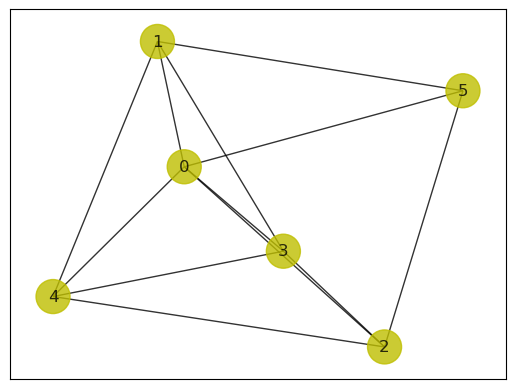

In [46]:
G = nx.Graph()
G.add_nodes_from(range(vertices_num))
G.add_edges_from(edges)

colors = ['y' for node in G.nodes()]    
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)   

In [47]:
hamiltonian_cost = SparsePauliOp.from_sparse_list([("ZZ", [i, j], 1) for (i, j) in edges], num_qubits=qubits_num)
print(hamiltonian_cost.to_matrix())

[[12.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  4.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  4.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j 12.+0.j]]


In [48]:
hamiltonian_mixer = SparsePauliOp.from_sparse_list([("X", [i], 1) for i in range(qubits_num)], num_qubits=qubits_num)
print(hamiltonian_mixer.to_matrix())

[[0.+0.j 1.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 1.+0.j 0.+0.j]]


In [49]:
ansatz = QuantumCircuit(qubits_num)
for i in range(qubits_num):
    ansatz.h(i)

gamma = [Parameter(f"γ_{i}") for i in range(P)]
beta = [Parameter(f"β_{i}") for i in range(P)]

for i in range(P):
    ansatz.barrier()

    cost_uni = PauliEvolutionGate(hamiltonian_cost, gamma[i], f'U(, γ_{i})')
    ansatz.append(cost_uni, range(qubits_num))
    ansatz.barrier()

    mixer_uni = PauliEvolutionGate(hamiltonian_mixer, beta[i], f'U(, β_{i})')
    ansatz.append(mixer_uni, range(qubits_num))

ansatz.measure_all()

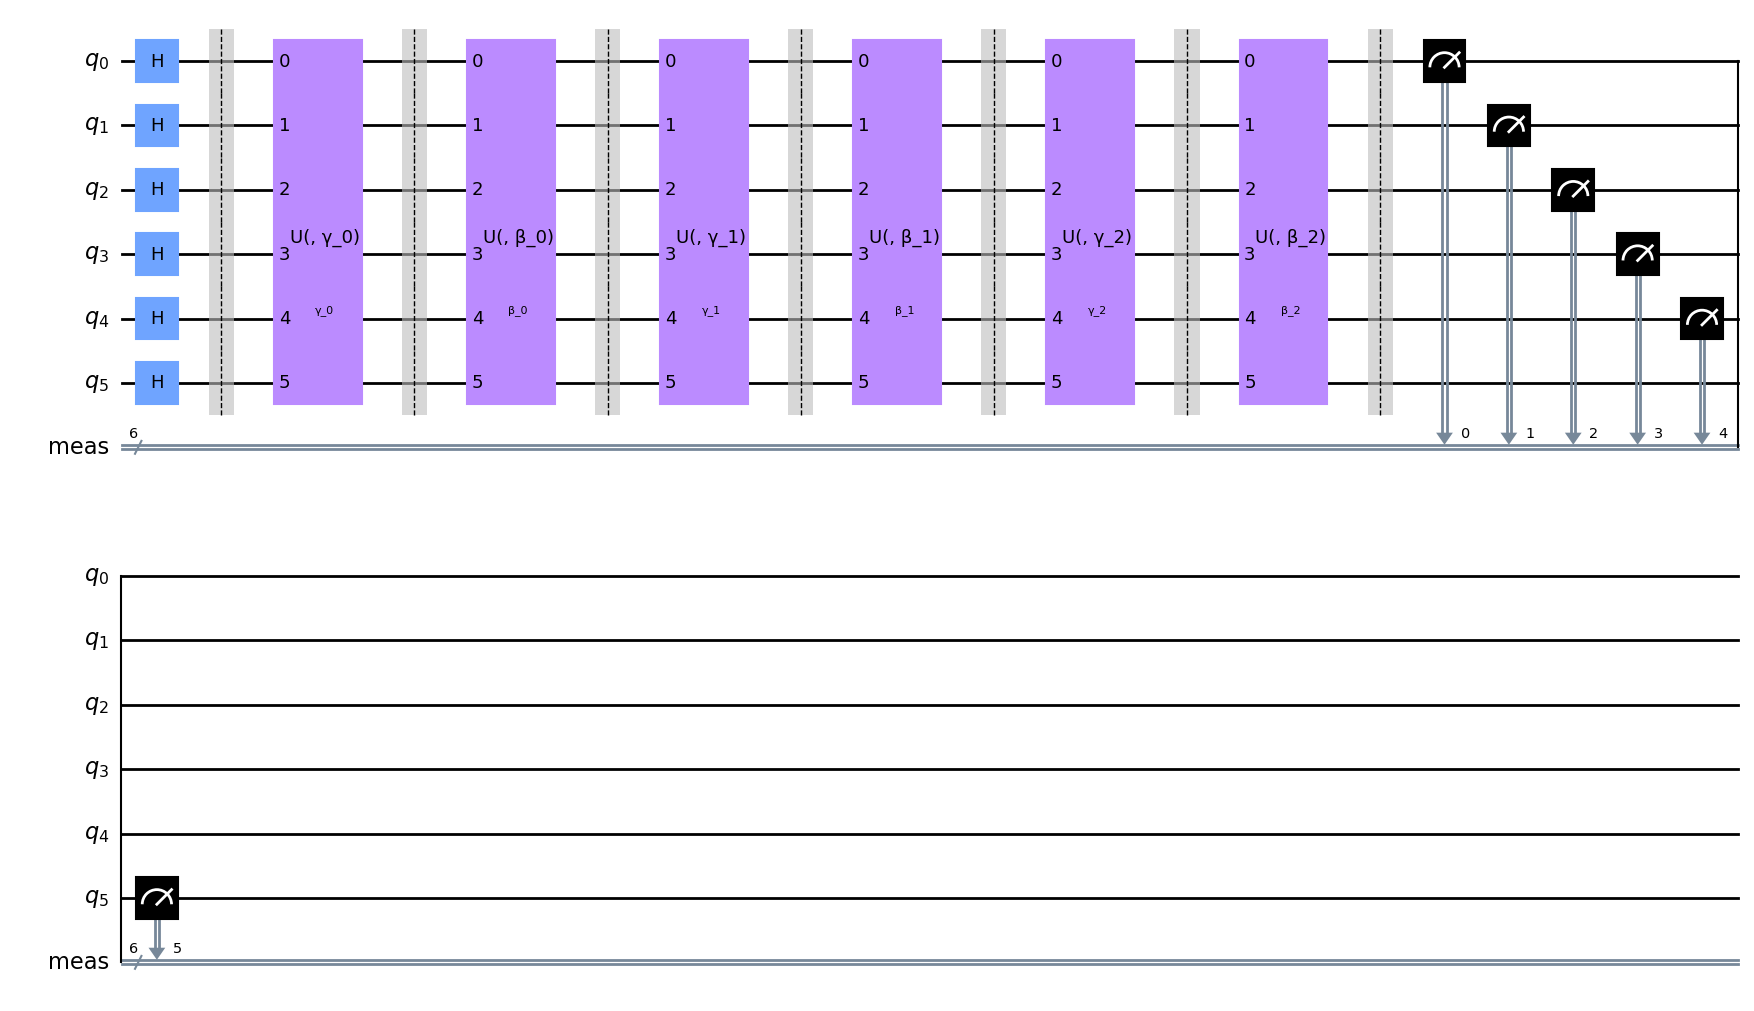

In [50]:
ansatz.draw('mpl')

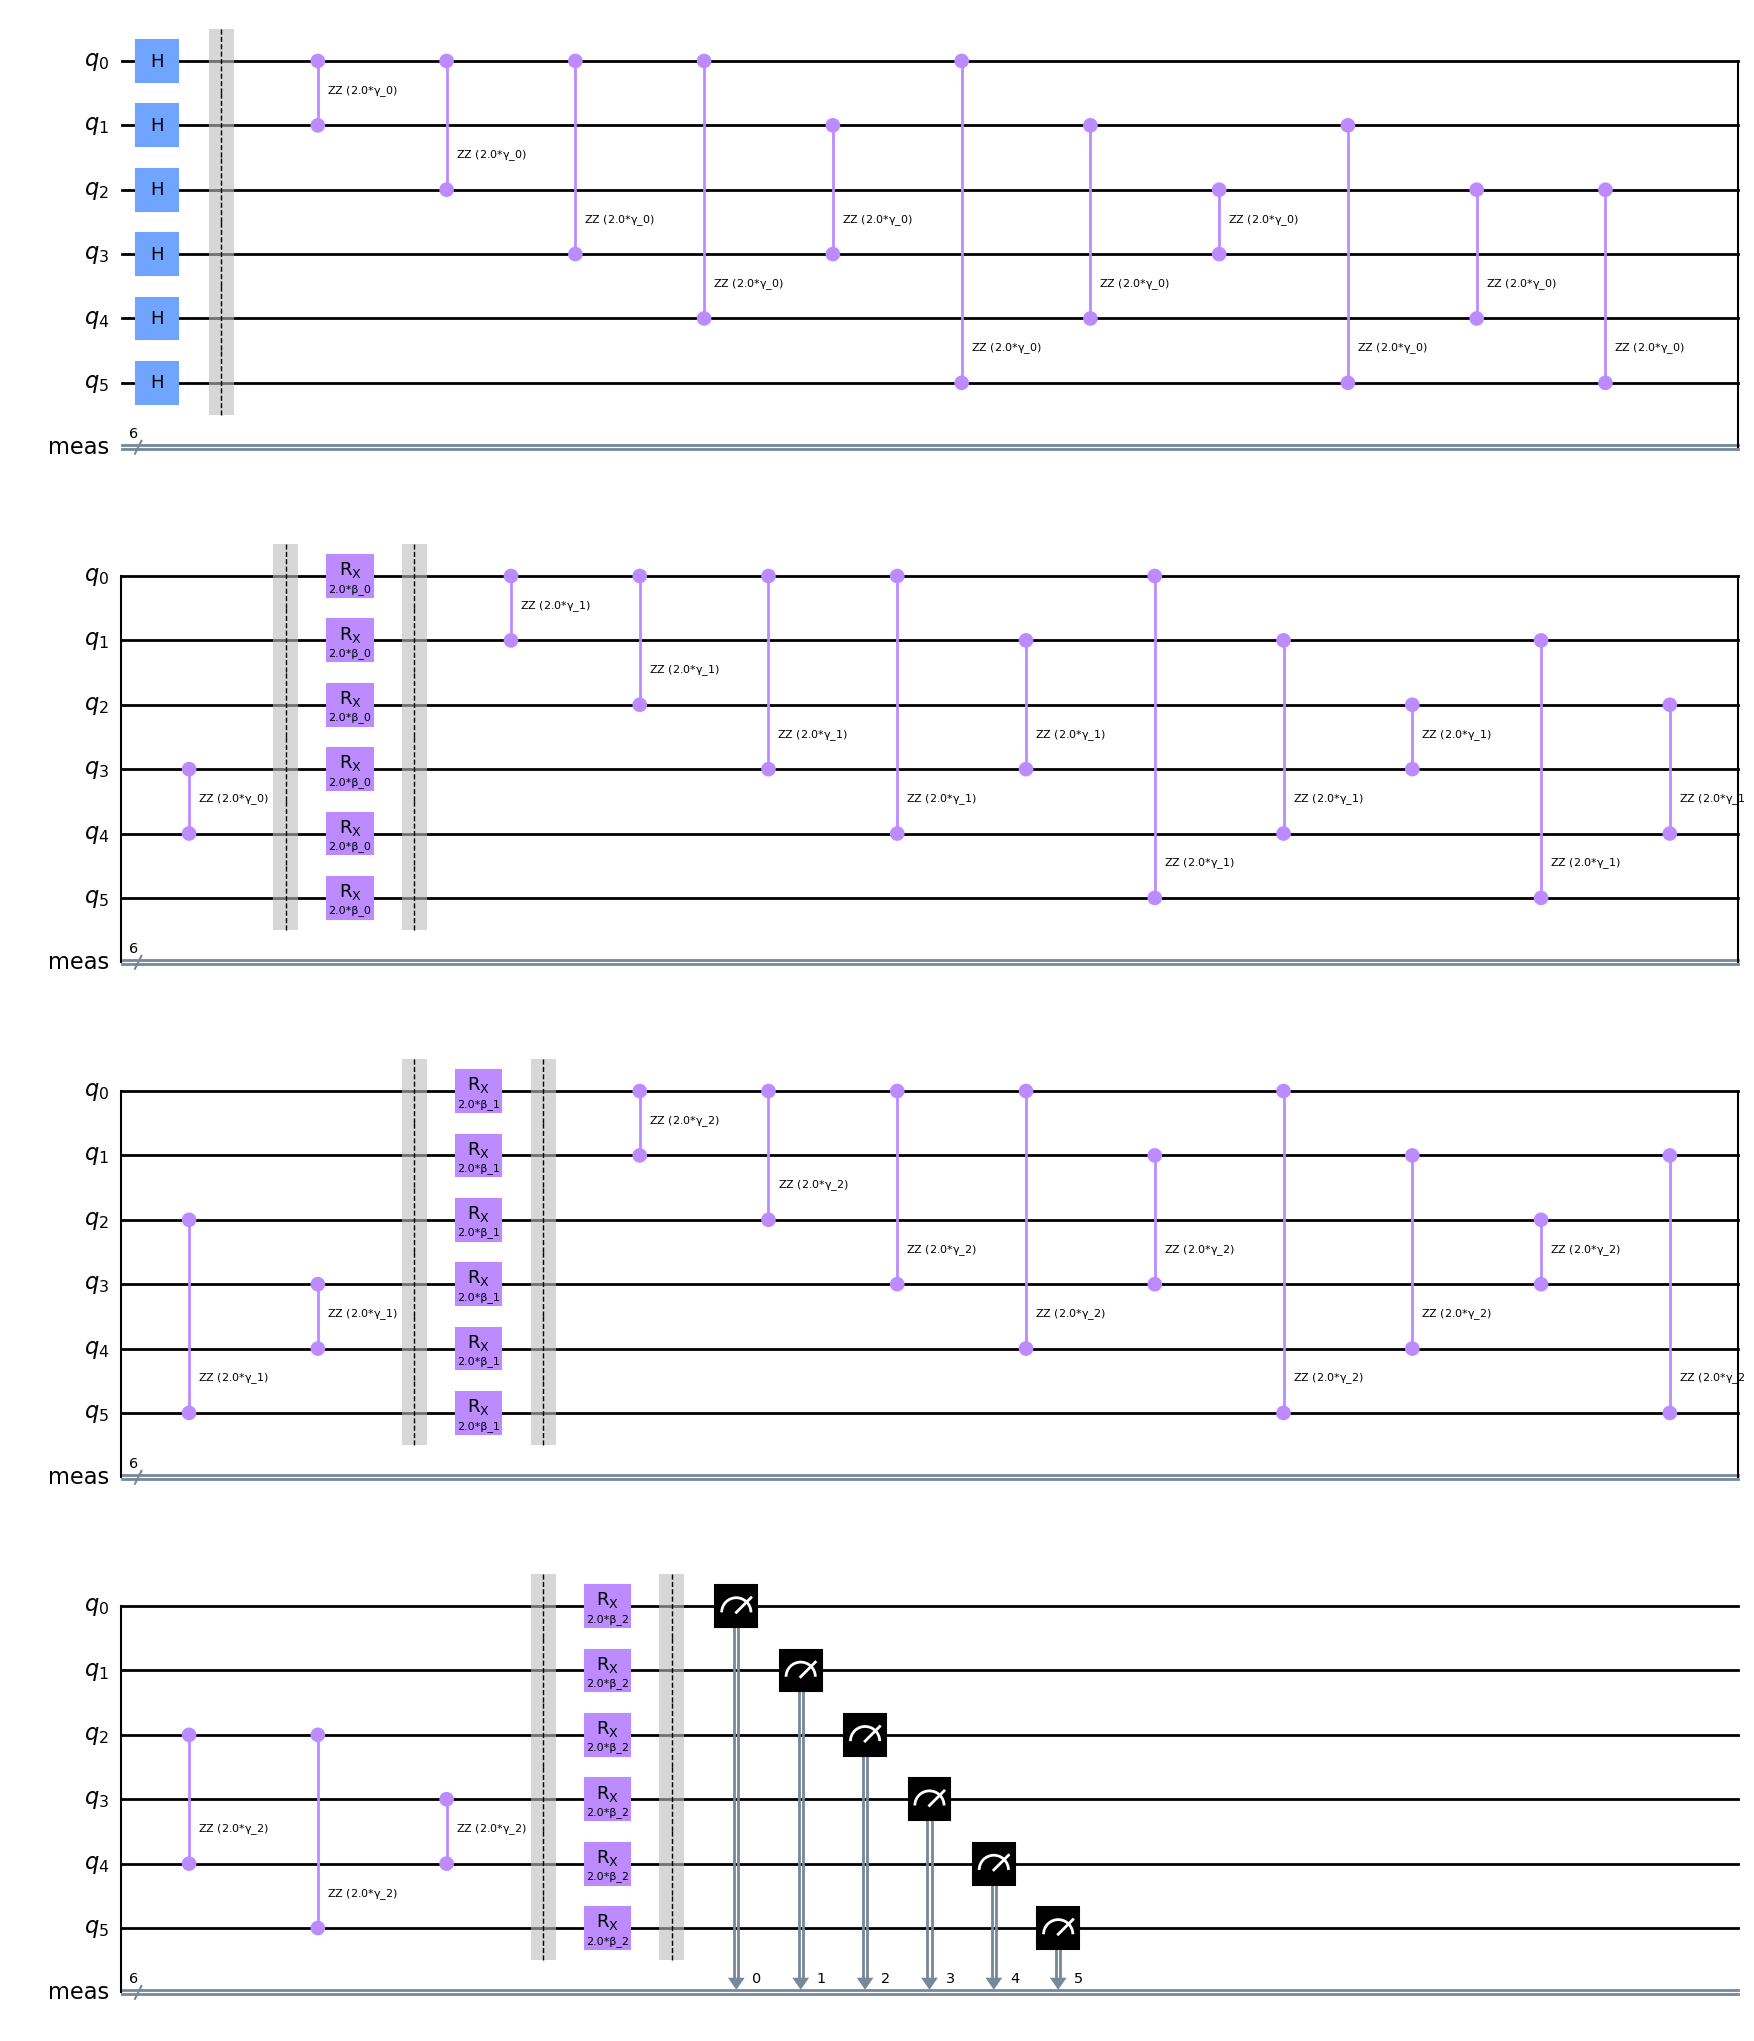

In [51]:
transpile(ansatz, optimization_level=3).draw('mpl')

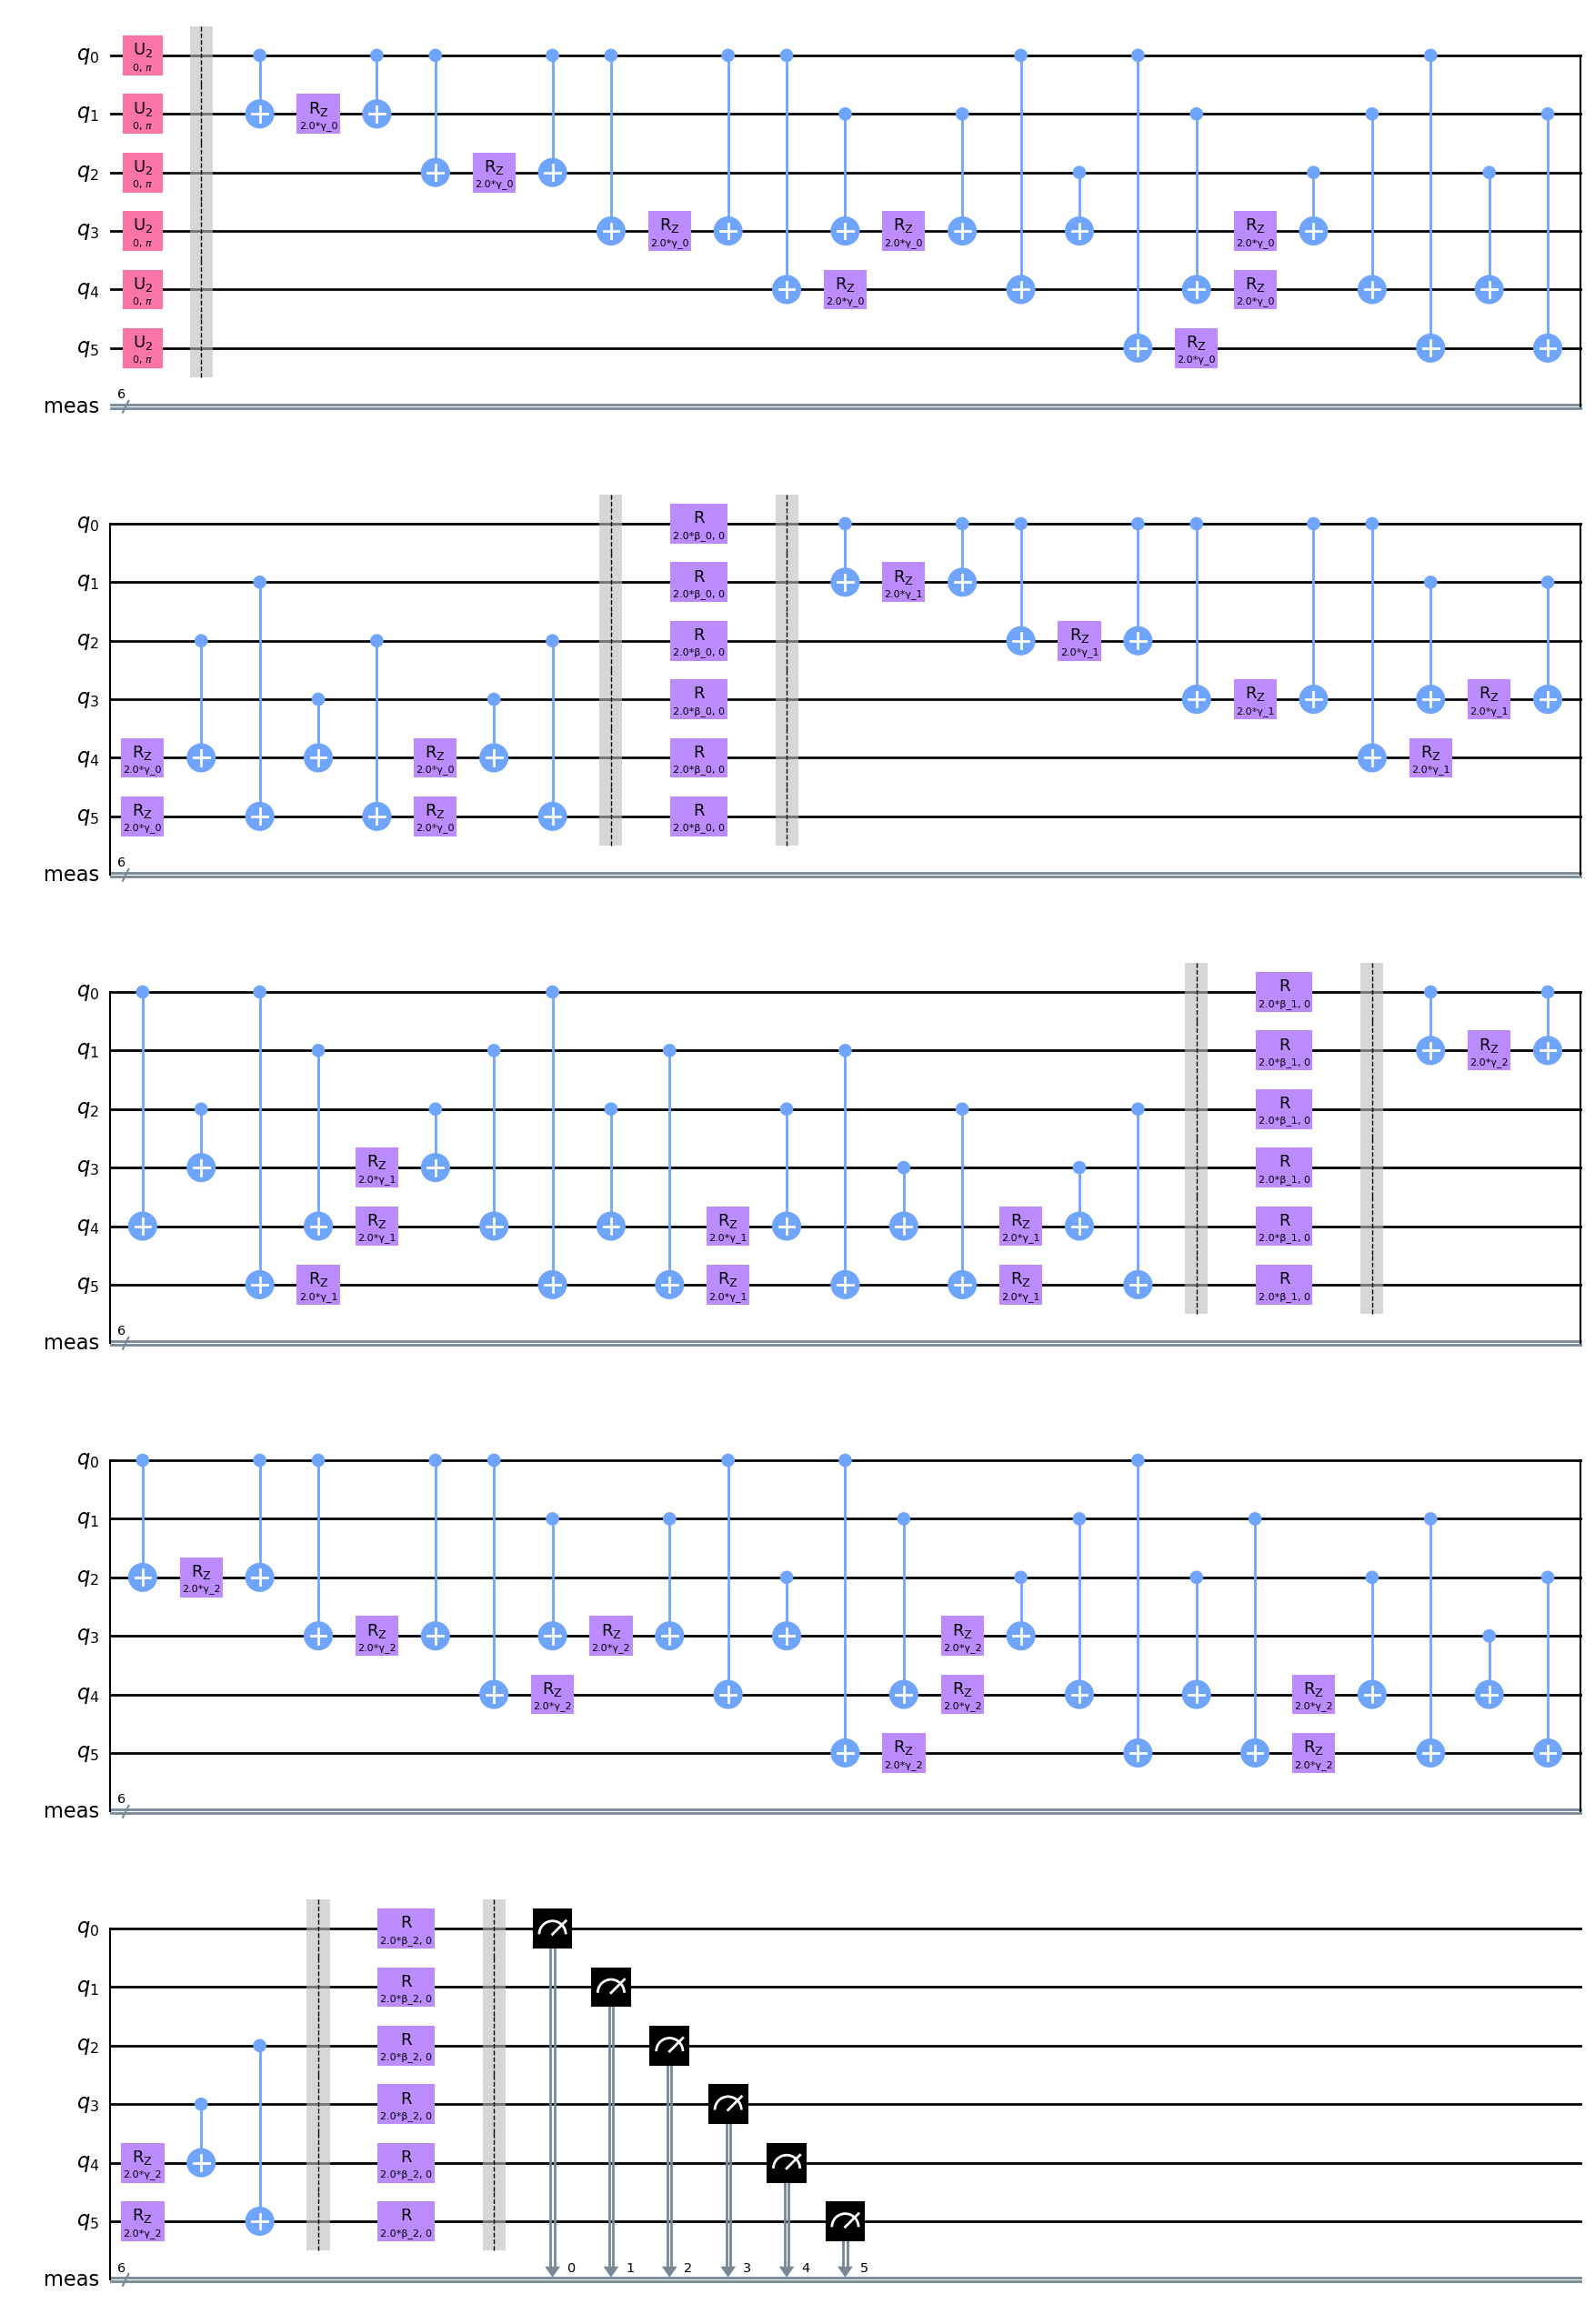

In [52]:
transpile(ansatz, optimization_level=3).decompose().draw('mpl')

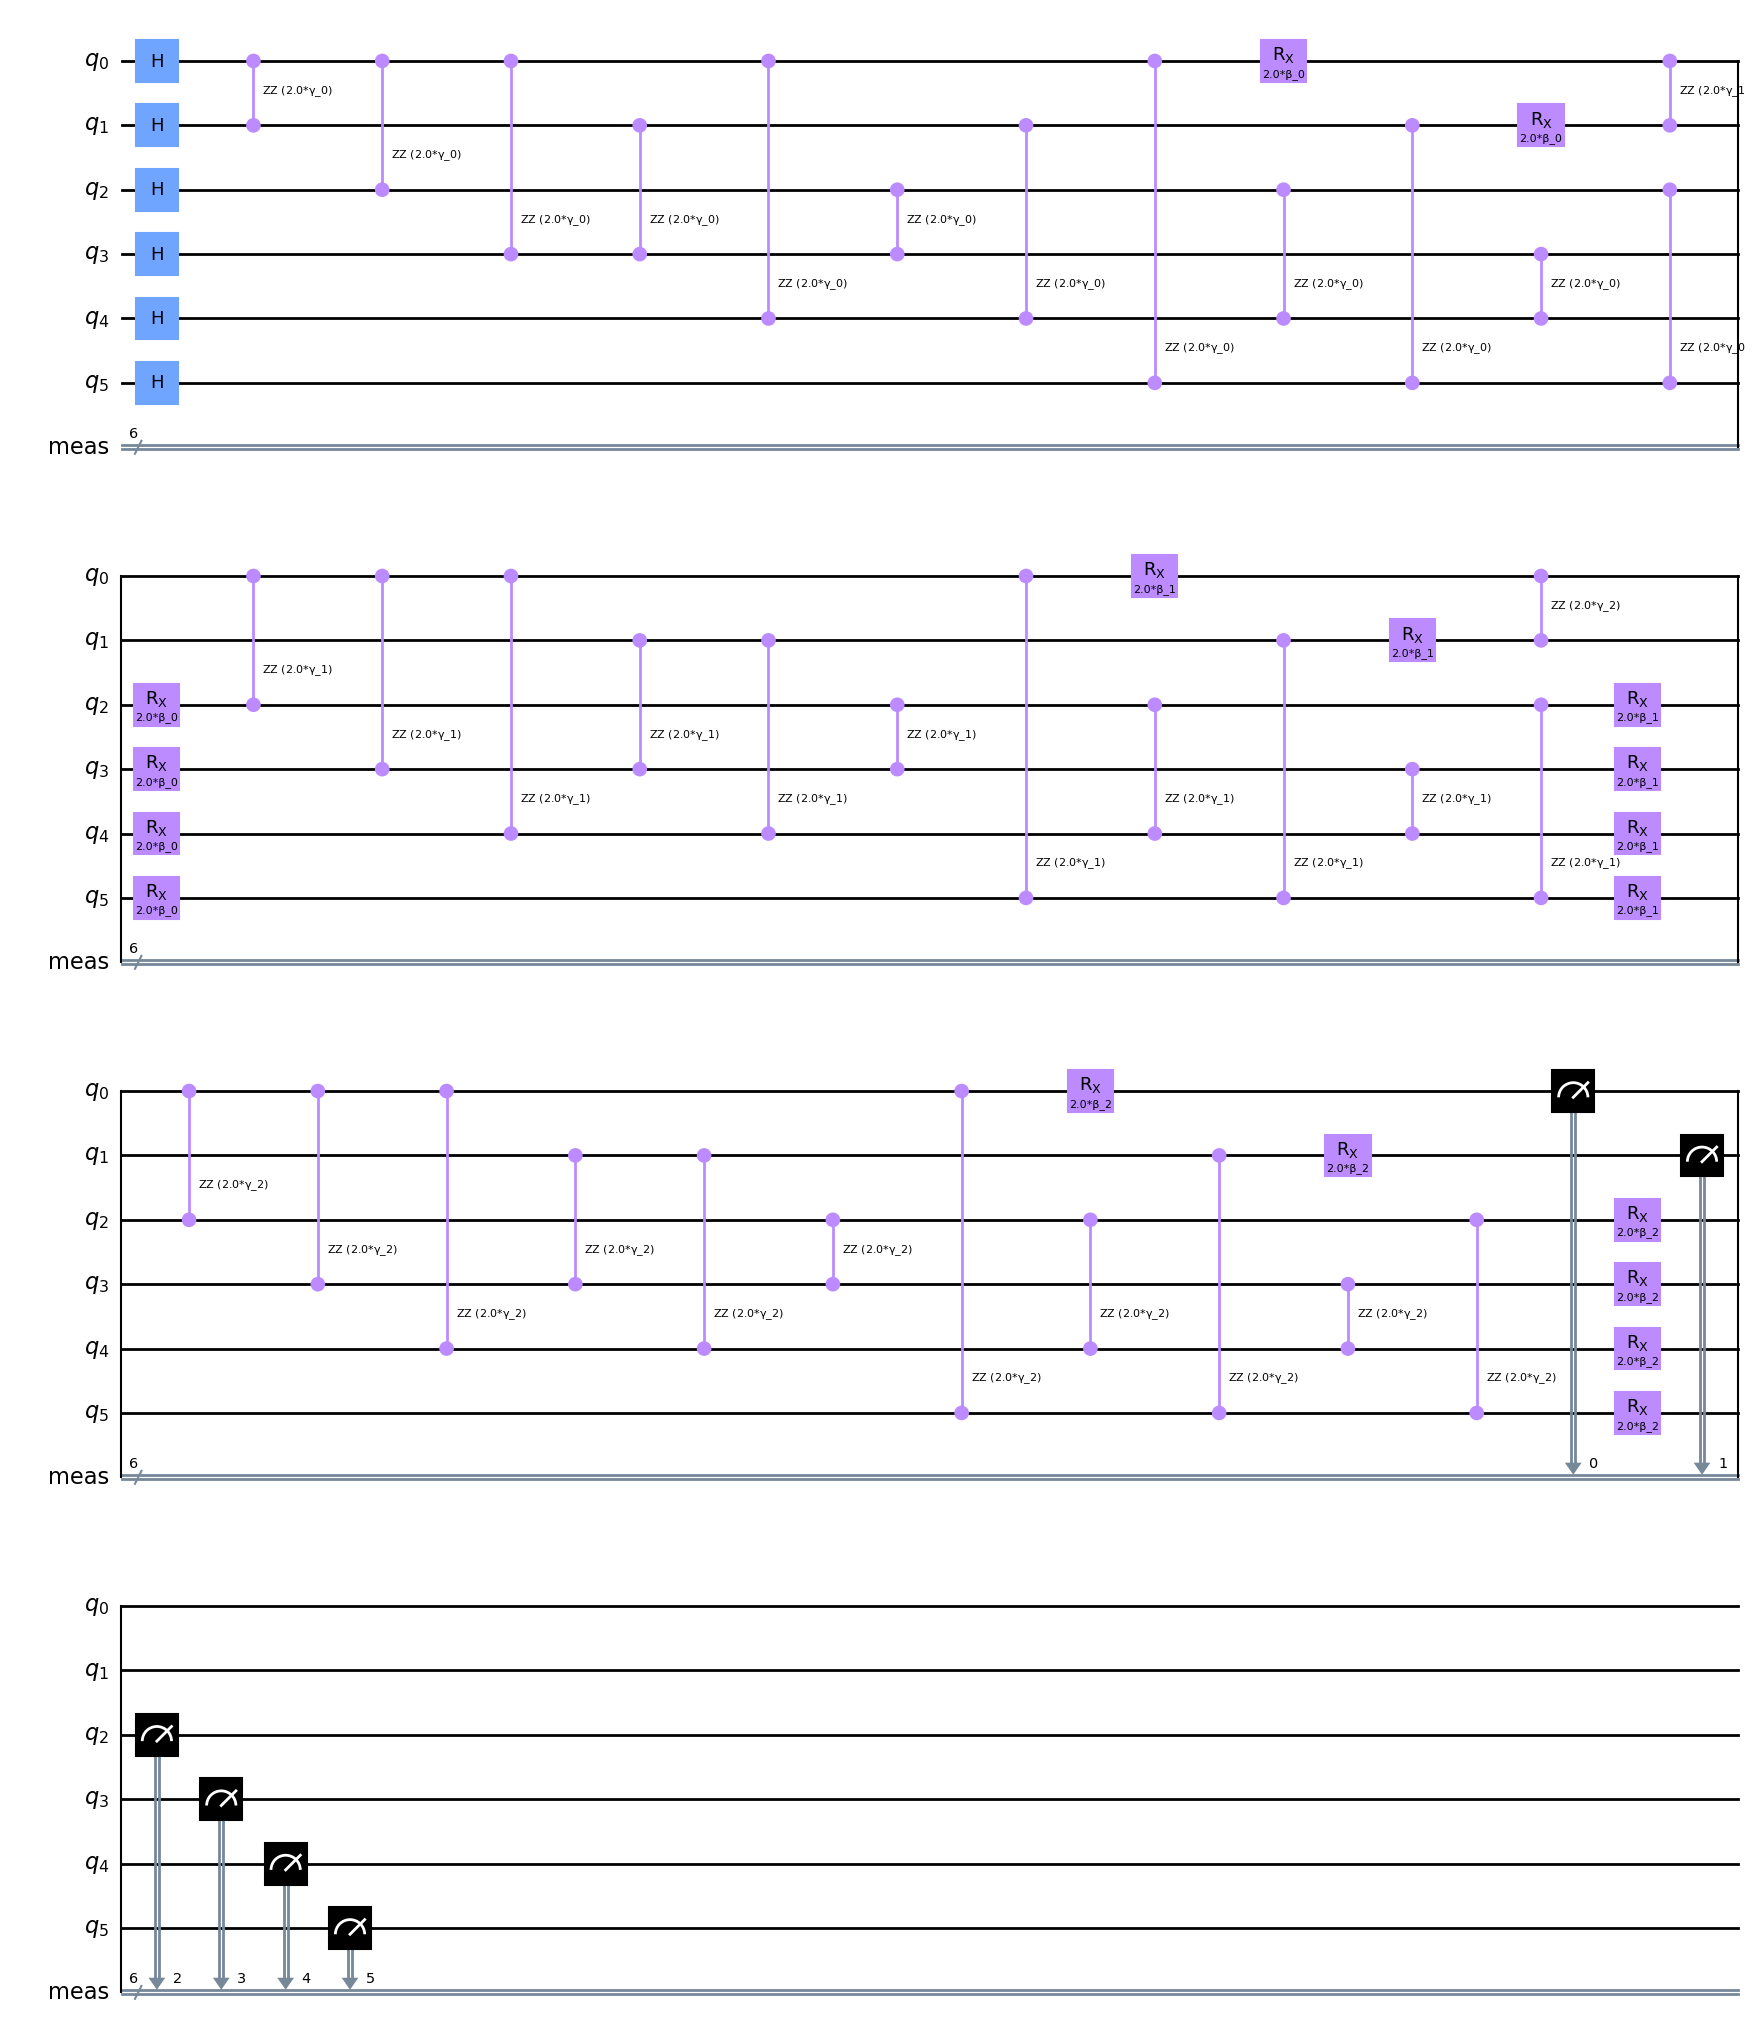

In [53]:
passmanager = PassManager()
passmanager.append(RemoveBarriers())    
ansatz = passmanager.run(ansatz)
ansatz = transpile(ansatz, optimization_level=3)
ansatz.draw('mpl')

In [54]:
def cost_func(params, ansatz=ansatz, hamiltonian=hamiltonian_cost):
    bound_ansatz = ansatz.assign_parameters(params)
    job = backend.run(bound_ansatz)
    result = job.result()
    counts = result.get_counts(bound_ansatz)
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True)[:int(2 ** qubits_num / 2)])
    cost = 0
    all_v = 0
    for (k, v) in counts.items():
        for i, j in edges:
            if k[i] == k[j]:
                cost += v
            else:
                cost -= v
            all_v += v
    return cost / all_v

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

convergence = []
def callback_fn(evals, para, fk, ss, sa):
    convergence.append(fk)

spsa = SPSA(maxiter=iter_spsa, callback=callback_fn)
result = spsa.minimize(cost_func, x0)

KeyboardInterrupt: 

In [ ]:
bound = ansatz.assign_parameters(result.x)
job = backend.run(bound)
result = job.result()
counts = result.get_counts(bound)

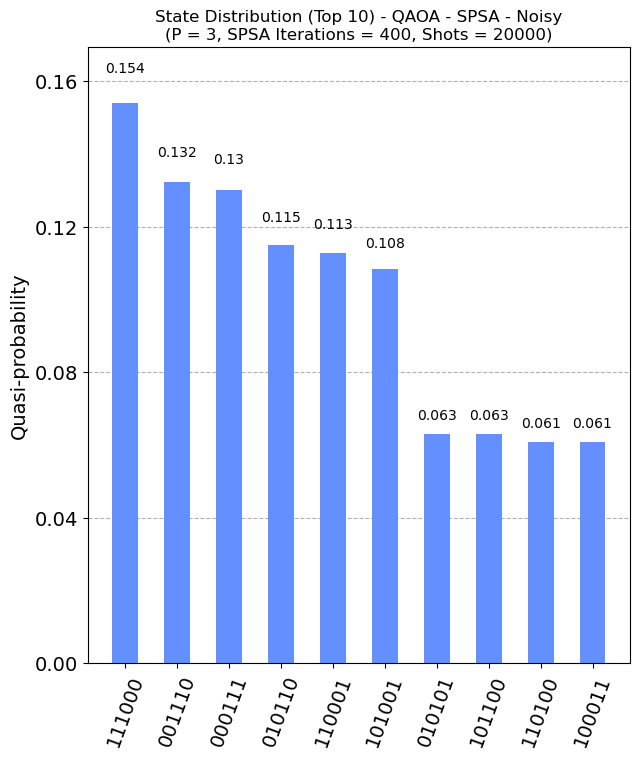

In [ ]:
NOISY_SIMULATOR = True
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - QAOA - SPSA - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(P = {P}, SPSA Iterations = {iter_spsa}, Shots = {shorts})", filename=f"distribution-qaoa-spsa-{'noisy' if NOISY_SIMULATOR else 'ideal'}-p_{P}-its_{iter_spsa}.pgf")
plot_distribution(counts, figsize=(7, 8), number_to_keep=10, sort='value_desc', title=f"State Distribution (Top 10) - QAOA - SPSA - {'Noisy' if NOISY_SIMULATOR else 'Ideal'}\n(P = {P}, SPSA Iterations = {iter_spsa}, Shots = {shorts})")

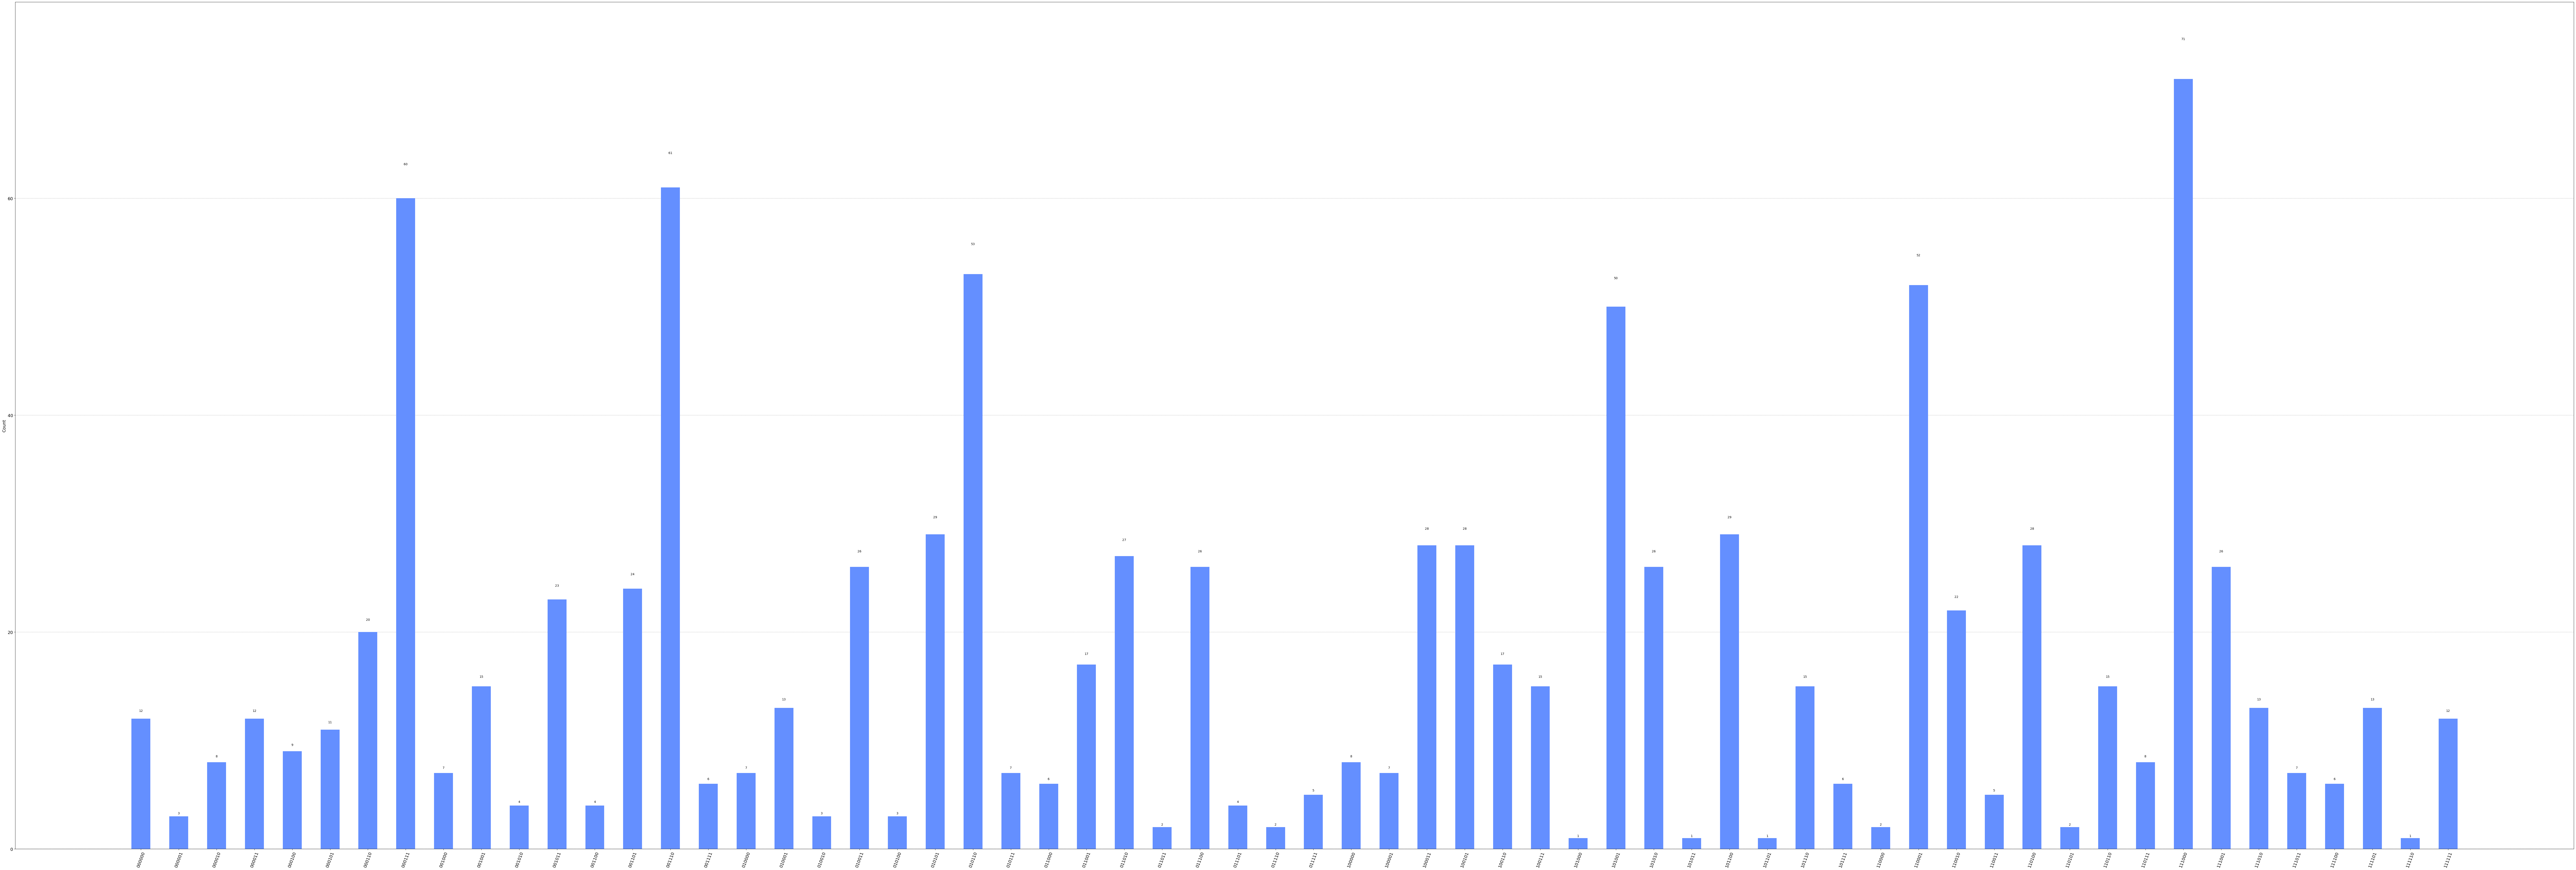

In [ ]:
from qiskit.visualization import plot_histogram as ph
ph(result.get_counts(bound),figsize=(150,50))